# Time Series Analysis

By: **Rodrigo Hernández Mota**

Basic time series analysis to determine the number of lags to use in the regression model.

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from conf import settings
from util.data_preparation import *
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

## Read and prepare data

In [21]:
from sqlalchemy import create_engine
engine = create_engine(CONNECTION_STRING)
col_names = {
    "division_economica": "economic_division",
    "genero": "gender",
    "edad": "age_range",
    "ta": "value",
    "etiqueta_mes": "variable"
}
sql_query = "SELECT * FROM insured_employment;"
df = pd.read_sql_query(sql_query, con=engine)
del df["fecha"]
df = df.rename(columns=col_names)
df["year"], df["month"] = df.variable.str.split("/").str
df["month"] = df["month"].replace(MONTHS)
df["year"] = df["year"].values.astype(np.float)
del df["variable"]
df = df.query("value != 'N/D'").reset_index(drop=True)
df["value"] = df.value.values.astype(np.float)
df["time"] = (df.year + (df.month-1) / 12).values

df.head()

,economic_division,gender,age_range,value,year,month,time
0,"Agricultura, ganadería, silvicultura, pesca y ...",Hombres,De 65 a 69 años.,770.0,2006.0,1,2006.0
1,"Agricultura, ganadería, silvicultura, pesca y ...",Mujeres,De 30 a 34 años.,1272.0,2006.0,1,2006.0
2,Comercio,Hombres,De 35 a 39 años.,16482.0,2006.0,1,2006.0
3,Comercio,Mujeres,De 35 a 39 años.,8884.0,2006.0,1,2006.0
4,Industrias extractivas,Hombres,De 70 a 74 años.,9.0,2006.0,1,2006.0


The dataset contains the possibility to make uso of several segregaton levels (i.e. economic_division, gender and age_rage). For each combination of the categories of the segregation variables we have one time serie data (from 2006 to 2017 by month).

The segregation levels are the following: 

In [22]:
cols = ["economic_division", "age_range", "gender"]

for col in cols:
    print("\n-----------")
    print("Variable: {}".format(col))
    print("Values: \n{}".format(df[col].unique()))


-----------
Variable: economic_division
Values: 
['Agricultura, ganadería, silvicultura, pesca y caza' 'Comercio'
 'Industrias extractivas' 'Servicios' 'Transportes y comunicaciones'
 'Industrias de transformación'
 'Industria eléctrica, captación y suministro de agua potable'
 'Industria de la construcción']

-----------
Variable: age_range
Values: 
['De 65 a 69 años.' 'De 30 a 34 años.' 'De 35 a 39 años.'
 'De 70 a 74 años.' 'De 45 a 49 años.' 'Menor a 15 años.'
 'De 15 a 19 años.' 'De 50 a 54 años.' 'De 55 a 59 años.'
 'De 60 a 64 años.' 'De 25 a 29 años.' 'De 75 ó más años'
 'De 20 a 24 años.' 'De 40 a 44 años.']

-----------
Variable: gender
Values: 
['Hombres' 'Mujeres']


This is one example of time series given the max. segregation level:

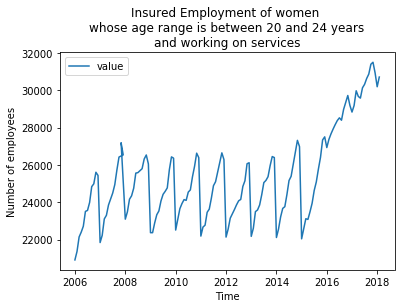

,economic_division,gender,age_range,value,year,month,time
70,Servicios,Mujeres,De 20 a 24 años.,20908.0,2006.0,1,2006.000000
299,Servicios,Mujeres,De 20 a 24 años.,21362.0,2006.0,2,2006.083333
542,Servicios,Mujeres,De 20 a 24 años.,22139.0,2006.0,3,2006.166667
741,Servicios,Mujeres,De 20 a 24 años.,22397.0,2006.0,4,2006.250000
865,Servicios,Mujeres,De 20 a 24 años.,22712.0,2006.0,5,2006.333333


In [23]:
sub_df = df.query("economic_division == 'Servicios' & age_range == 'De 20 a 24 años.' & gender == 'Mujeres'")

# Plot
sub_df.plot(x="time", y="value")
plt.title("Insured Employment of women \nwhose age range is between 20 and 24 years\nand working on services")
plt.xlabel("Time")
plt.ylabel("Number of employees")
plt.show()

# DF
sub_df.head()

## Time Series Lags

To get the number of lags to use in a general regression model we have to consider the possible (viable) lags
for each time series resulting of the combinations of the seggregation level. 

As an example, these are the viable lags for the previous sub_df shown before:

In [24]:
def optimize_lags(time_series_vector, plot=False, max_lags=None):
    max_lags = max_lags if max_lags else MAX_LAGS

    def is_significant(value, threshold):
        return (value <= -threshold) or (value >= threshold)

    def confident_lags(pacf_vector, threshold):
        compare_zip = zip(map(lambda x: is_significant(x, threshold), pacf_vector),
                          range(len(pacf_vect)))
        return [val[1] for val in compare_zip if val[0]]

    significance_threshold = stats.norm.ppf(1 - ALPHA) / np.sqrt(len(time_series_vector))
    if plot:
        plot_acf(time_series_vector, lags=max_lags)
        plot_pacf(time_series_vector, lags=max_lags)
    pacf_vect = pacf(time_series_vector, nlags=max_lags)
    lags = confident_lags(pacf_vect, significance_threshold)
    return lags


Viable lags for sub_df: [0, 1, 9, 10, 11, 12, 13, 15, 16]


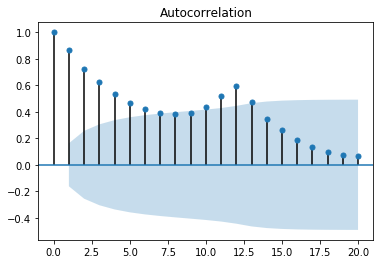

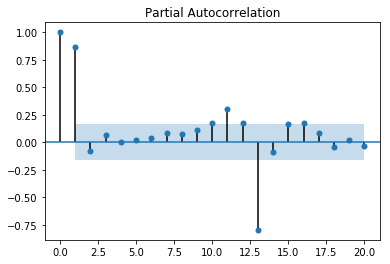

In [25]:
viable_lags = optimize_lags(sub_df.value, plot=True, max_lags=20)

print("\nViable lags for sub_df: {}".format(viable_lags))

The autocorrelation functions shows the correlation pf a given lag to the originl time series. The partial autocorrelation shows a similar analysis but discounting the effects of the in-between lags. 

In this case, we base our lag-selection based on the partial autocorrelation and using a selection criteria based on the significance level: stats.norm.ppf(1 - ALPHA) / np.sqrt(len(time_series_vector))

This significance test assumes normality. 

Generating the viable lags for any combination of the segregation level we have: 

In [26]:
def suggested_lags(df, cols, frequency=0.05, plot=False):

    def get_by_recursive_combinations(df, cols, n_lags=[]):
        unique_vals = df[cols[0]].unique()
        for val in unique_vals:
            sub_df = df.query("{} == '{}'".format(cols[0], val))
            if sub_df.value.std() < 1:
                continue
            n_lags += (optimize_lags(sub_df.value) if len(cols)==1 else get_by_recursive_combinations(
                sub_df, cols[1:], n_lags=[]))
        return list(filter(lambda x: x > 0, n_lags))

    n_lags = get_by_recursive_combinations(df, cols, n_lags=[])
    n, unique_lags = len(n_lags), np.unique(n_lags)
    freq_lags = [len(list(filter(lambda x: x == u, n_lags))) / n for u in unique_lags]
    lag_df = pd.DataFrame({"lag": unique_lags, "freq": freq_lags})
    if plot:
        lag_df.plot.bar(x="lag", y="freq", color="blue", alpha=0.6)
        plt.ylabel("Frequency")
        plt.title("Suggested lags frequency")
    suggested = lag_df.query("freq > {}".format(frequency)).lag.values
    return [val for val in suggested if val < MAX_LAGS]

Suggested lags where at least 5% of all combinations coincide and < MAX_LAGS: [1, 2, 3, 6, 7]


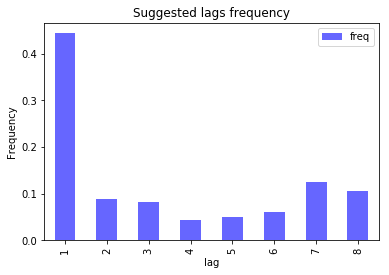

In [27]:
lags = suggested_lags(df, cols, frequency=0.05, plot=True)

print("Suggested lags where at least 5% of all combinations coincide and < MAX_LAGS: {}".format(lags))

## Add Lags to General DF

The following functions adds the lags to the general df:

In [28]:
def add_lags(sub_df, lags):
    original_index = sub_df.index
    response = sub_df.reset_index(drop=True)[["value"]]
    for lag in lags:
        temp = response[["value"]].iloc[:-lag]
        temp.index = temp.index + lag
        response["t-{}".format(lag)] = temp
    response.index = original_index
    del response["value"]
    return pd.concat([sub_df, response], axis=1)

def add_lags_recursive(df, cols, lags, result_df=pd.DataFrame([])):
    unique_vals = df[cols[0]].unique()
    for val in unique_vals:
        sub_df = df.query("{} == '{}'".format(cols[0], val))
        result_df = pd.concat([result_df, add_lags(sub_df, lags)], axis=0) \
            if len(cols) == 1 else add_lags_recursive(sub_df, cols[1:], lags, result_df=result_df)
    return result_df


In [29]:
df = add_lags_recursive(df, cols, lags)

Now with a simple query we can see how at the max segregation level we have the corresponding lags for the response variable time series.

In [30]:
df.query("economic_division == 'Servicios' & age_range == 'De 20 a 24 años.' & gender == 'Mujeres'").head(15)

,economic_division,gender,age_range,value,year,month,time,t-1,t-2,t-3,t-6,t-7
70,Servicios,Mujeres,De 20 a 24 años.,20908.0,2006.0,1,2006.000000,NaN,NaN,NaN,NaN,NaN
299,Servicios,Mujeres,De 20 a 24 años.,21362.0,2006.0,2,2006.083333,20908.0,NaN,NaN,NaN,NaN
542,Servicios,Mujeres,De 20 a 24 años.,22139.0,2006.0,3,2006.166667,21362.0,20908.0,NaN,NaN,NaN
741,Servicios,Mujeres,De 20 a 24 años.,22397.0,2006.0,4,2006.250000,22139.0,21362.0,20908.0,NaN,NaN
865,Servicios,Mujeres,De 20 a 24 años.,22712.0,2006.0,5,2006.333333,22397.0,22139.0,21362.0,NaN,NaN
1081,Servicios,Mujeres,De 20 a 24 años.,23508.0,2006.0,6,2006.416667,22712.0,22397.0,22139.0,NaN,NaN
1333,Servicios,Mujeres,De 20 a 24 años.,23562.0,2006.0,7,2006.500000,23508.0,22712.0,22397.0,20908.0,NaN
1508,Servicios,Mujeres,De 20 a 24 años.,23987.0,2006.0,8,2006.583333,23562.0,23508.0,22712.0,21362.0,20908.0
1823,Servicios,Mujeres,De 20 a 24 años.,24836.0,2006.0,9,2006.666667,23987.0,23562.0,23508.0,22139.0,21362.0
2118,Servicios,Mujeres,De 20 a 24 años.,24989.0,2006.0,10,2006.750000,24836.0,23987.0,23562.0,22397.0,22139.0


As a final step we sort the index and drop NaN rows.

In [31]:
df = df.sort_index().dropna()

Now we separate into the datastet for the model and temporal validation. 

In [32]:
temporal_validation = df.query("time >= 2017").sort_values("time").reset_index(drop=True)
df = df.query("time < 2017").sort_values("time").reset_index(drop=True)

In [33]:
del df["time"]
del temporal_validation["time"]

## Temporal Validation

The year 2017 is used as a temporal validation for the model. 

In [34]:
print("\nAvailable data: {}".format(temporal_validation.shape))
temporal_validation.head(10)


Available data: (3010, 11)


,economic_division,gender,age_range,value,year,month,t-1,t-2,t-3,t-6,t-7
0,Servicios,Mujeres,De 15 a 19 años.,5528.0,2017.0,1,5727.0,5774.0,5686.0,5745.0,5356.0
1,"Agricultura, ganadería, silvicultura, pesca y ...",Mujeres,De 30 a 34 años.,3457.0,2017.0,1,3328.0,3334.0,3306.0,2888.0,2905.0
2,Comercio,Mujeres,De 70 a 74 años.,144.0,2017.0,1,123.0,120.0,118.0,104.0,108.0
3,Industria de la construcción,Mujeres,De 65 a 69 años.,117.0,2017.0,1,111.0,107.0,106.0,102.0,103.0
4,"Industria eléctrica, captación y suministro de...",Mujeres,De 50 a 54 años.,179.0,2017.0,1,182.0,179.0,176.0,166.0,159.0
5,Industrias de transformación,Hombres,De 45 a 49 años.,24977.0,2017.0,1,24426.0,24467.0,24268.0,23844.0,23691.0
6,Industrias de transformación,Mujeres,De 45 a 49 años.,14493.0,2017.0,1,14082.0,14080.0,13963.0,13582.0,13433.0
7,Industrias extractivas,Hombres,De 30 a 34 años.,406.0,2017.0,1,406.0,453.0,464.0,466.0,470.0
8,Servicios,Hombres,De 65 a 69 años.,4300.0,2017.0,1,4118.0,4166.0,4160.0,4032.0,4037.0
9,Transportes y comunicaciones,Hombres,De 20 a 24 años.,5443.0,2017.0,1,5554.0,5710.0,5593.0,5612.0,5467.0


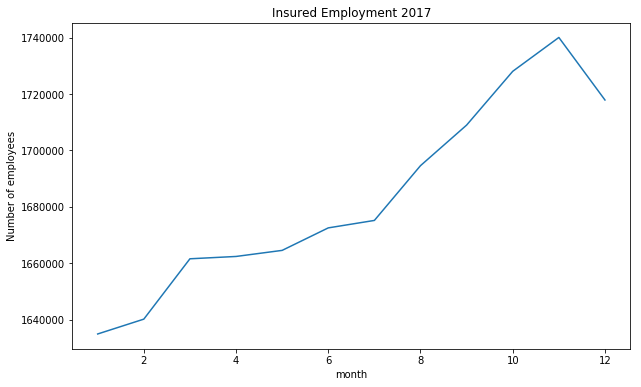

In [36]:
temporal_validation.query("year < 2018").groupby("month").sum().value.plot(figsize=(10, 6))
plt.title("Insured Employment 2017")
plt.ylabel("Number of employees")
plt.show()